# Psuedobulk DESeq2 with decoupler and PyDESeq2
**Authorship:** Adam Klie (last updated: 08/27/2023)<br>
***
**Description:** This notebook performs a

# Set-up

In [16]:
# Global Imports
import os
import sys
import yaml
import random
import time
import datetime
import logging
import scanpy as sc
import decoupler as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import DESeq2
import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 3

# Local imports
sys.path.append("/cellar/users/aklie/data/igvf/bin")
from utils import make_dirs

In [146]:
# Dataset
dataset_name = "igvf_sc-islet_10X-Multiome"
results_dir = "/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_cellular_programs/decoupler/results"
pseudobulk = "predicted_cell_type_by_batch-condition"
cell_type = "SC_beta"
condition = "IFNg"
batch = "DM041"

# Inputs
in_date = "25Aug23"
in_analysis = "create_pseudobulks"
in_run = "2545199730_20230829-095741"
in_prefix = f"pseudo_bulk_{cell_type}_{batch}" if batch else f"pseudo_bulk_{cell_type}"
in_file = f"{in_prefix}_{condition}.h5ad" if condition else f"{in_prefix}.h5ad"
in_data = os.path.join(results_dir, dataset_name, in_date, "pseudobulk_analysis", in_analysis, in_run, "pseudobulk_h5ads", pseudobulk, in_file)
print(in_data)

# Outputs
out_date = "25Aug23"
out_analysis = "pseudobulk_deseq2"
time_id = time.strftime("%Y%m%d-%H%M%S")
run_id =  random.getrandbits(32)
run = str(run_id) + "_" + time_id
if condition:
    if batch:
        out_dir = os.path.join(results_dir, dataset_name, out_date, "pseudobulk_analysis", out_analysis, pseudobulk, cell_type, batch, condition, run)
    else:
        out_dir = os.path.join(results_dir, dataset_name, out_date, "pseudobulk_analysis", out_analysis, pseudobulk, cell_type, condition, run)
else:
    if batch:
        out_dir = os.path.join(results_dir, dataset_name, out_date, "pseudobulk_analysis", out_analysis, pseudobulk, cell_type, batch, run)
    else:
        out_dir = os.path.join(results_dir, dataset_name, out_date, "pseudobulk_analysis", out_analysis, pseudobulk, cell_type, run)
print(make_dirs(out_dir))

# Method params
design_factors = ['time_point', 'condition']
contunious_factors = None
reference_factor = 'condition'
reference_value = 'control'
refit_cooks = True
n_cpus = 3

/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_cellular_programs/decoupler/results/igvf_sc-islet_10X-Multiome/25Aug23/pseudobulk_analysis/create_pseudobulks/2545199730_20230829-095741/pseudobulk_h5ads/predicted_cell_type_by_batch-condition/pseudo_bulk_SC_beta_DM041_IFNg.h5ad
/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_cellular_programs/decoupler/results/igvf_sc-islet_10X-Multiome/25Aug23/pseudobulk_analysis/pseudobulk_deseq2/predicted_cell_type_by_batch-condition/SC_beta/DM041/IFNg/1400908964_20230829-114734


In [147]:
# Make a params file
data_params = {
    "in_data": in_data,
    "pseudobulk": pseudobulk,
    "cell_type": cell_type,
    "condition": condition,
    "batch": batch,
    "out_dir": out_dir
}
method_params = {
    "design_factors": design_factors,
    "contunious_factors": contunious_factors,
    "reference_factor": reference_factor,
    "reference_value": reference_value,
    "refit_cooks": refit_cooks,
    "n_cpus": n_cpus,
}
version_params = {
    "time_id": time_id,
    "run_id": run_id,
    "Python": sys.version[:5],
    "Scanpy": sc.__version__,
    "decoupler": dc.__version__,
    "pydeseq2": pydeseq2.__version__,
}
params = {"data": data_params, "run": method_params, "versions": version_params}
params_file = os.path.join(out_dir,"deseq2_params.yaml")
if not os.path.exists(os.path.join(out_dir, params_file)):
    with open(os.path.join(out_dir, params_file), "w") as f:
        yaml.dump(params, f)
else:
    print("params.yaml already exists, will not overwrite")

# Load data

In [148]:
# The data to load from pseudobulk
pdata = sc.read_h5ad(in_data)
pdata

AnnData object with n_obs × n_vars = 6 × 13971
    obs: 'orig.ident', 'batch', 'condition', 'time_point', 'sample', 'predicted.cell.type', 'predicted_cell_type', 'psbulk_n_cells', 'psbulk_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'
    layers: 'psbulk_props'

In [149]:
# Double check your covariates
pdata.obs.condition.value_counts(), pdata.obs.batch.value_counts(), pdata.obs.predicted_cell_type.value_counts()

(IFNg       3
 control    3
 Name: condition, dtype: int64,
 DM041    6
 Name: batch, dtype: int64,
 SC_beta    6
 Name: predicted_cell_type, dtype: int64)

# Run DESeq2

In [150]:
# Build DESeq2 object
dds = DeseqDataSet(
    adata=pdata,
    design_factors=design_factors,
    continuous_factors=contunious_factors,
    ref_level=[reference_factor, reference_value],  # [factor, value]
    refit_cooks=refit_cooks,
    n_cpus=n_cpus,
)

/tmp/ipykernel_628939/2758861245.py:2: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(


In [151]:
# Compute LFCs
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 83.73 seconds.

Fitting dispersion trend curve...
... done in 9.43 seconds.

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/pydeseq2/dds.py:363: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 50.53 seconds.

Fitting LFCs...
... done in 6.69 seconds.

Refitting 0 outliers.



In [152]:
# Check available contrasts
contrast_factors = pdata.obs[reference_factor].unique()
contrast_factors

array(['IFNg', 'control'], dtype=object)

Running DESeq2 for IFNg vs control


Running Wald tests...


Log2 fold change & Wald test p-value: condition IFNg vs control


... done in 2.56 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,26.067682,0.578150,0.604033,0.957150,0.338492,0.999681
A1BG-AS1,62.806484,0.225104,0.343205,0.655887,0.511897,0.999681
A1CF,1505.041626,0.800461,0.504046,1.588070,0.112271,0.787533
A2ML1-AS1,9.203255,-1.101853,1.110276,-0.992413,0.320996,NaN
A3GALT2,23.707281,-0.673360,0.646953,-1.040817,0.297960,0.999681
...,...,...,...,...,...,...
ZWILCH,23.972000,0.128615,0.631596,0.203635,0.838639,0.999681
ZXDC,338.395630,0.176078,0.300935,0.585102,0.558479,0.999681
ZYG11B,294.248810,-0.105354,0.080034,-1.316363,0.188052,0.931372
ZYX,11.666997,0.465869,1.247027,0.373584,0.708714,NaN


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition IFNg vs control


... done in 19.98 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,26.067682,0.026271,0.130192,0.957150,0.338492,0.999681
A1BG-AS1,62.806484,0.029235,0.147516,0.655887,0.511897,0.999681
A1CF,1505.041626,0.052973,0.137596,1.588070,0.112271,0.787533
A2ML1-AS1,9.203255,-0.013657,0.156264,-0.992413,0.320996,NaN
A3GALT2,23.707281,-0.026051,0.155304,-1.040817,0.297960,0.999681
...,...,...,...,...,...,...
ZWILCH,23.972000,0.005311,0.134277,0.203635,0.838639,0.999681
ZXDC,338.395630,0.028839,0.149044,0.585102,0.558479,0.999681
ZYG11B,294.248810,0.144270,0.357344,-1.316363,0.188052,0.931372
ZYX,11.666997,0.004290,0.127243,0.373584,0.708714,NaN


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


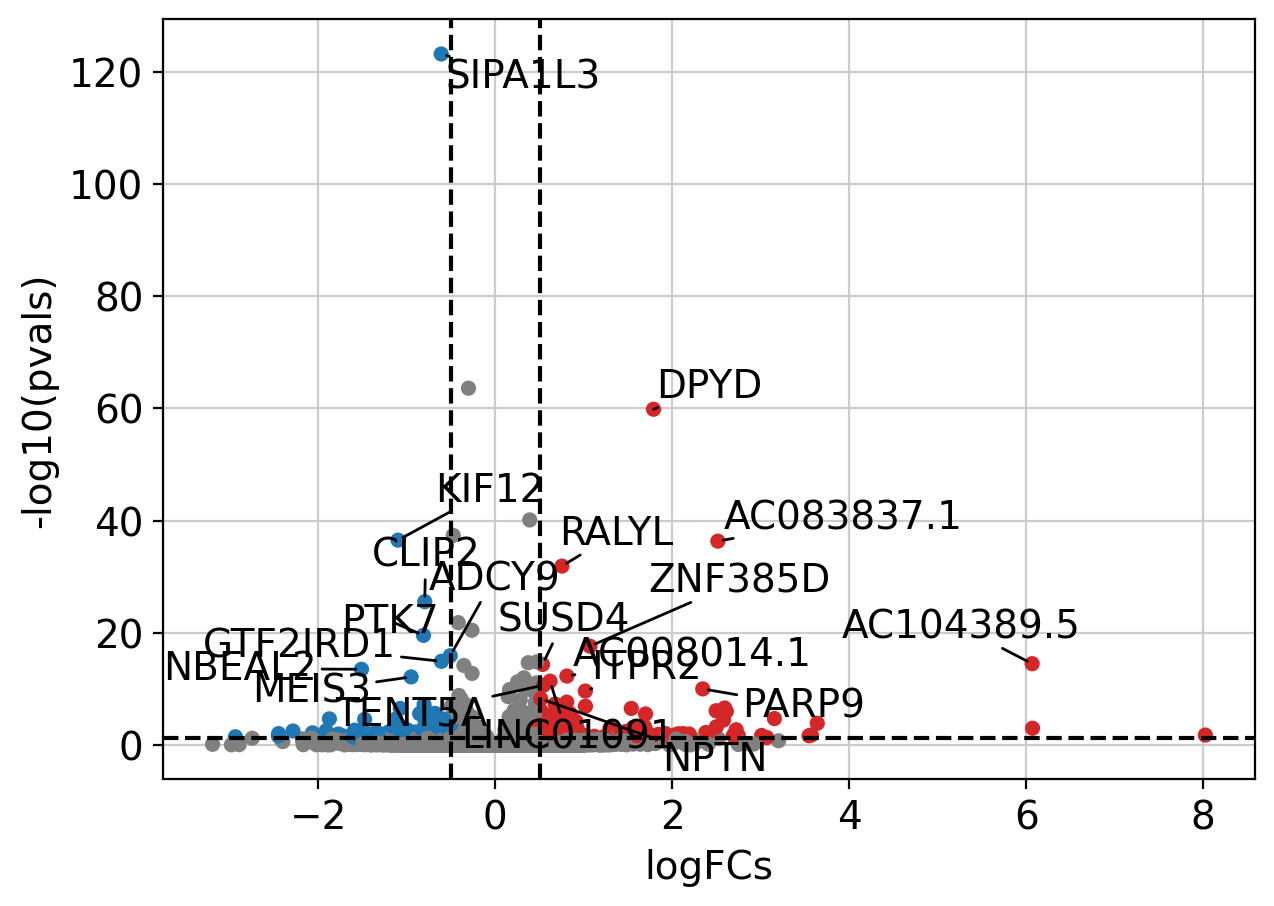

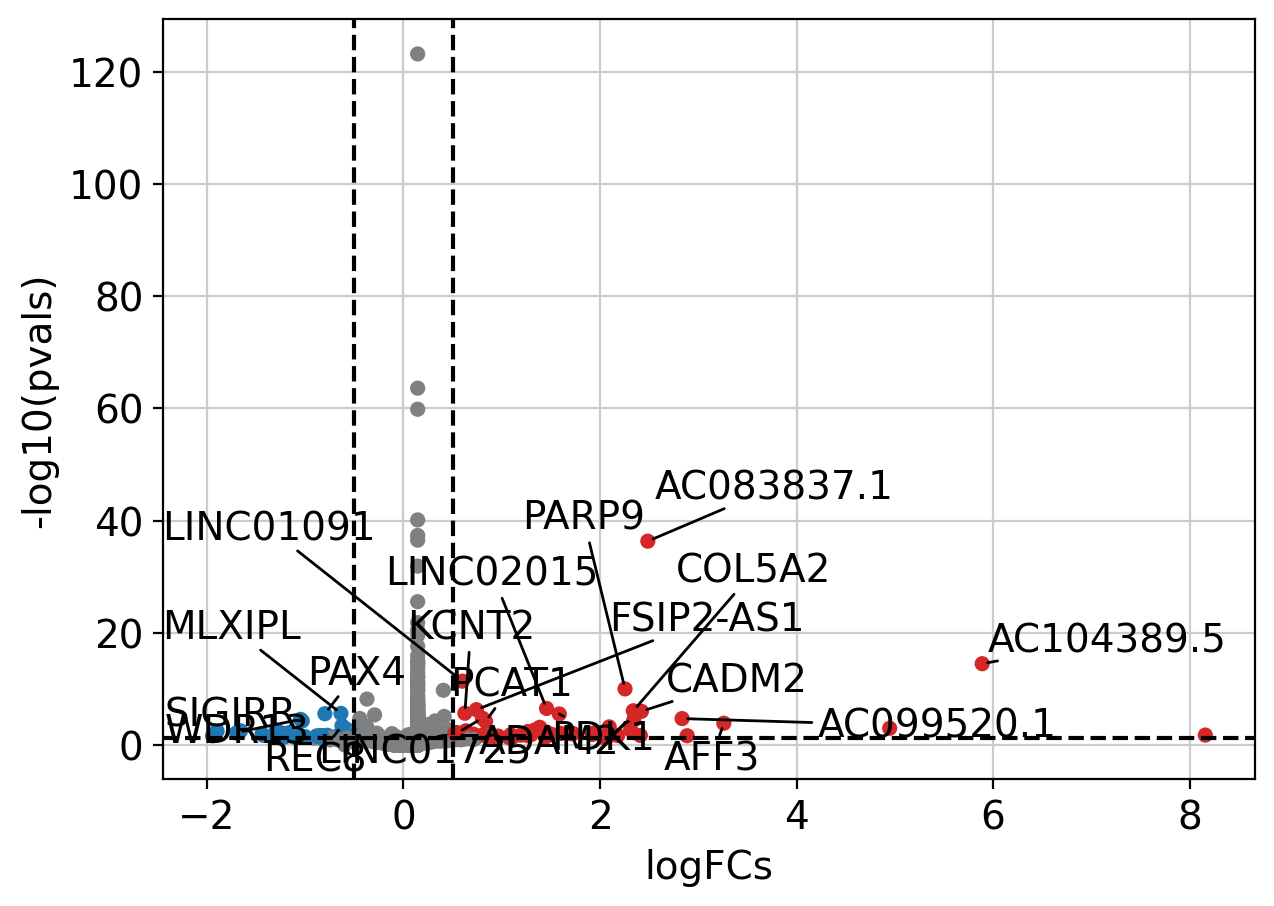

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/pydeseq2/utils.py:1185: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/pydeseq2/utils.py:1185: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/pydeseq2/utils.py:1185: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))


In [153]:
# For each contrast, get DESeq2 statistics and generate a few plots
for curr_contrast in contrast_factors:
    if curr_contrast == reference_value:
        continue
    else:
        curr_contrast = curr_contrast.replace("_", "-")
        print(f"Running DESeq2 for {curr_contrast} vs {reference_value}")
        stat_res = DeseqStats(dds, contrast=[reference_factor, curr_contrast, reference_value], n_cpus=n_cpus)
        stat_res.summary()
        results_df = stat_res.results_df
        results_df.sort_values("padj").to_csv(os.path.join(out_dir, f"{curr_contrast}_vs_{reference_value}.tsv"), sep="\t")
        dc.plot_volcano_df(
            results_df, 
            x='log2FoldChange', 
            y='padj', 
            top=20, 
            save=os.path.join(out_dir, f"volcano_plot_{curr_contrast}_vs_{reference_value}.png")
        )
        stat_res.lfc_shrink(coeff=f"{reference_factor}_{curr_contrast}_vs_{reference_value}")
        shrunk_results_df = stat_res.results_df
        shrunk_results_df.sort_values("padj").to_csv(os.path.join(out_dir, f"{curr_contrast}_vs_{reference_value}_shrunkLFC.tsv"), sep="\t")
        dc.plot_volcano_df(
            shrunk_results_df, 
            x='log2FoldChange', 
            y='padj', 
            top=20, 
            save=os.path.join(out_dir, f"volcano_plot_{curr_contrast}_vs_{reference_value}_shrunkLFCs.png")
        )

# DONE!

---

# Scratch

## Single contrast DESeq2

In [ ]:
# Extract contrast 
stat_res = DeseqStats(dds, contrast=["condition", 'IFNg', 'control'], n_cpus=3)

In [ ]:
# Compute Wald test
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition palmitate vs control


... done in 2.91 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,28.197479,-0.182927,0.291155,-0.628280,0.529820,0.997738
A1BG-AS1,63.135761,0.002798,0.243289,0.011499,0.990825,0.999598
A1CF,1973.849609,0.165639,0.362691,0.456693,0.647892,0.997738
A2ML1-AS1,8.233173,-0.189464,0.524504,-0.361224,0.717932,0.997738
A3GALT2,25.162668,-0.146469,0.243953,-0.600398,0.548241,0.997738
...,...,...,...,...,...,...
ZWILCH,22.005219,-0.405419,0.176298,-2.299631,0.021469,0.997738
ZXDC,380.121246,0.103415,0.103668,0.997563,0.318491,0.997738
ZYG11B,317.672852,-0.178194,0.151178,-1.178704,0.238516,0.997738
ZYX,13.607073,-0.086035,0.452618,-0.190083,0.849244,0.999220


In [ ]:
stat_res.results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,28.197479,-0.182927,0.291155,-0.628280,0.529820,0.997738
A1BG-AS1,63.135761,0.002798,0.243289,0.011499,0.990825,0.999598
A1CF,1973.849609,0.165639,0.362691,0.456693,0.647892,0.997738
A2ML1-AS1,8.233173,-0.189464,0.524504,-0.361224,0.717932,0.997738
A3GALT2,25.162668,-0.146469,0.243953,-0.600398,0.548241,0.997738
...,...,...,...,...,...,...
ZWILCH,22.005219,-0.405419,0.176298,-2.299631,0.021469,0.997738
ZXDC,380.121246,0.103415,0.103668,0.997563,0.318491,0.997738
ZYG11B,317.672852,-0.178194,0.151178,-1.178704,0.238516,0.997738
ZYX,13.607073,-0.086035,0.452618,-0.190083,0.849244,0.999220


In [ ]:
# Shrink LFCs
stat_res.lfc_shrink(coeff='condition_IFNg_vs_control')

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition IFNg vs control


... done in 20.34 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,26.067682,0.026271,0.130192,0.957150,0.338492,0.999681
A1BG-AS1,62.806484,0.029235,0.147516,0.655887,0.511897,0.999681
A1CF,1505.041626,0.052973,0.137596,1.588070,0.112271,0.787533
A2ML1-AS1,9.203255,-0.013657,0.156264,-0.992413,0.320996,NaN
A3GALT2,23.707281,-0.026051,0.155304,-1.040817,0.297960,0.999681
...,...,...,...,...,...,...
ZWILCH,23.972000,0.005311,0.134277,0.203635,0.838639,0.999681
ZXDC,338.395630,0.028839,0.149044,0.585102,0.558479,0.999681
ZYG11B,294.248810,0.144270,0.357344,-1.316363,0.188052,0.931372
ZYX,11.666997,0.004290,0.127243,0.373584,0.708714,NaN


In [ ]:
# Extract results
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,26.067682,0.026271,0.130192,0.957150,0.338492,0.999681
A1BG-AS1,62.806484,0.029235,0.147516,0.655887,0.511897,0.999681
A1CF,1505.041626,0.052973,0.137596,1.588070,0.112271,0.787533
A2ML1-AS1,9.203255,-0.013657,0.156264,-0.992413,0.320996,NaN
A3GALT2,23.707281,-0.026051,0.155304,-1.040817,0.297960,0.999681
...,...,...,...,...,...,...
ZWILCH,23.972000,0.005311,0.134277,0.203635,0.838639,0.999681
ZXDC,338.395630,0.028839,0.149044,0.585102,0.558479,0.999681
ZYG11B,294.248810,0.144270,0.357344,-1.316363,0.188052,0.931372
ZYX,11.666997,0.004290,0.127243,0.373584,0.708714,NaN


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


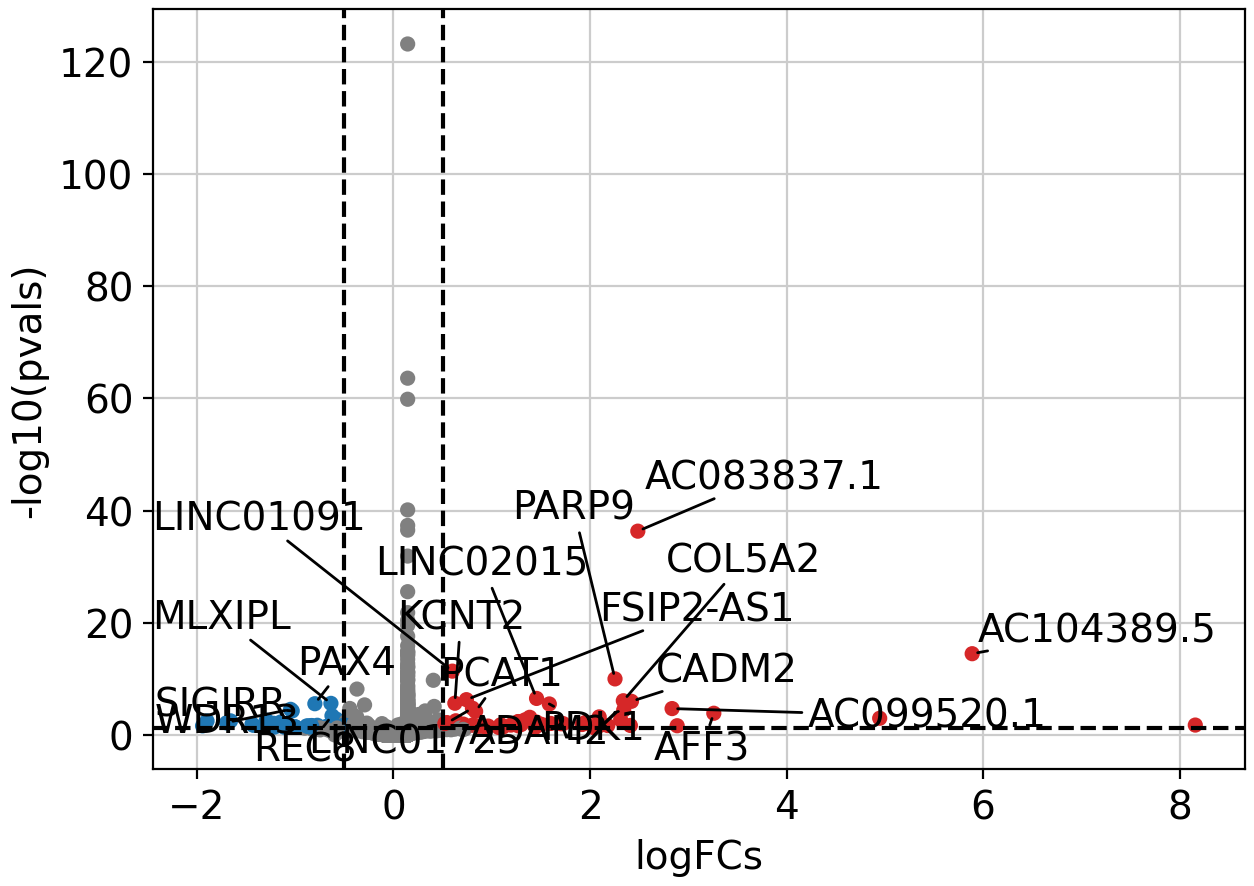

In [ ]:
dc.plot_volcano_df(
    results_df, 
    x='log2FoldChange', 
    y='padj', 
    top=20, 
    save=os.path.join(out_dir, "celltype_condition", "IFNg_vs_control.png")
)